In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.12.0


In [21]:
batch_size = 128
image_size = 224
test_size = 0.2

# Load Data and division of Data
Total validation images = 16

Total training images = 5216

There is lot of training images compare to validation images and division between these two dataset not in 80:20 ratio.

In below cell, divsion of 80:20 performed after merging all the validation and training images in a list of files.

In [22]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [23]:
train = get_training_data('Dataset/train')
test = get_training_data('Dataset/test')
val = get_training_data('Dataset/val')

In [24]:
print(f'Before division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}\n')


combined_array = np.concatenate((train, val))
np.random.shuffle(combined_array)
print(f'Total number of images : training_images + validation_images = {len(combined_array)}\n')

train = combined_array[:int(len(combined_array) * 0.8)]
val = combined_array[int(len(combined_array) * 0.8):]
print(f'After division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 16

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


# Data Visualization and Pre-processing

<AxesSubplot:ylabel='count'>

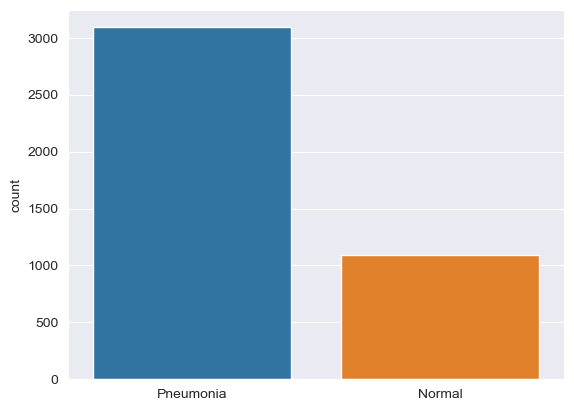

In [25]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

In [26]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [27]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [28]:
# resize data for deep learning 
x_train = x_train.reshape(-1, image_size, image_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, image_size, image_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, image_size, image_size, 3)
y_test = np.array(y_test)

# Data Augmentation

In [29]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    )


datagen.fit(x_train)

In [30]:
x_train.shape

(4185, 224, 224, 3)

# Residual Net Model (After tuning)

In [56]:
base_model3 = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
# base_model3.trainable = False
for layers in base_model3.layers[:100]:
    layers.trainable = False

model3 = tf.keras.Sequential([
        base_model3,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(512, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Dense(512, activation=tf.nn.relu),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid),
        ])

model3.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 19,454,977
Non-trainable params: 4,134,784
_________________________________________________________________


Below code block shows, number of layers for base model (Inception) which is 311. and out of 311 layers, I choose to freeze 200 layers while training it means we will not be training those 200 freezed layers.

In [57]:
len(base_model3.layers)

175

In [58]:
checkpoint_cb3= tf.keras.callbacks.ModelCheckpoint("model3_resnet.h5",
                                                    save_best_only=True)

early_stopping_cb3 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=5, mode = 'min',restore_best_weights=True)

### Train the model

In [59]:
history = model3.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 10, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb3,early_stopping_cb3])

Epoch 1/10
10/10 [==============================] - 86s 8s/step - loss: 1.7170 - accuracy: 0.5656 - val_loss: 1890.9928 - val_accuracy: 0.7555
Epoch 2/10
10/10 [==============================] - 77s 8s/step - loss: 0.8167 - accuracy: 0.6625 - val_loss: 164.4524 - val_accuracy: 0.7555
Epoch 3/10
10/10 [==============================] - 74s 8s/step - loss: 0.5276 - accuracy: 0.7188 - val_loss: 5109.6035 - val_accuracy: 0.7555
Epoch 4/10
10/10 [==============================] - 75s 8s/step - loss: 0.3637 - accuracy: 0.7969 - val_loss: 2275.5173 - val_accuracy: 0.7555
Epoch 5/10
10/10 [==============================] - 74s 8s/step - loss: 0.3631 - accuracy: 0.7969 - val_loss: 3360.3396 - val_accuracy: 0.7555
Epoch 6/10
10/10 [==============================] - 74s 8s/step - loss: 0.4331 - accuracy: 0.7812 - val_loss: 3721.2222 - val_accuracy: 0.7555
Epoch 7/10
10/10 [==============================] - 73s 8s/step - loss: 0.4119 - accuracy: 0.8031 - val_loss: 1377.5623 - val_accuracy: 0.7555


Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [60]:
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 27s 1s/step - loss: 224.1034 - accuracy: 0.6250
Loss of the model is -  224.1034393310547
20/20 [==============================] - 27s 1s/step - loss: 224.1034 - accuracy: 0.6250
Accuracy of the model is -  62.5 %


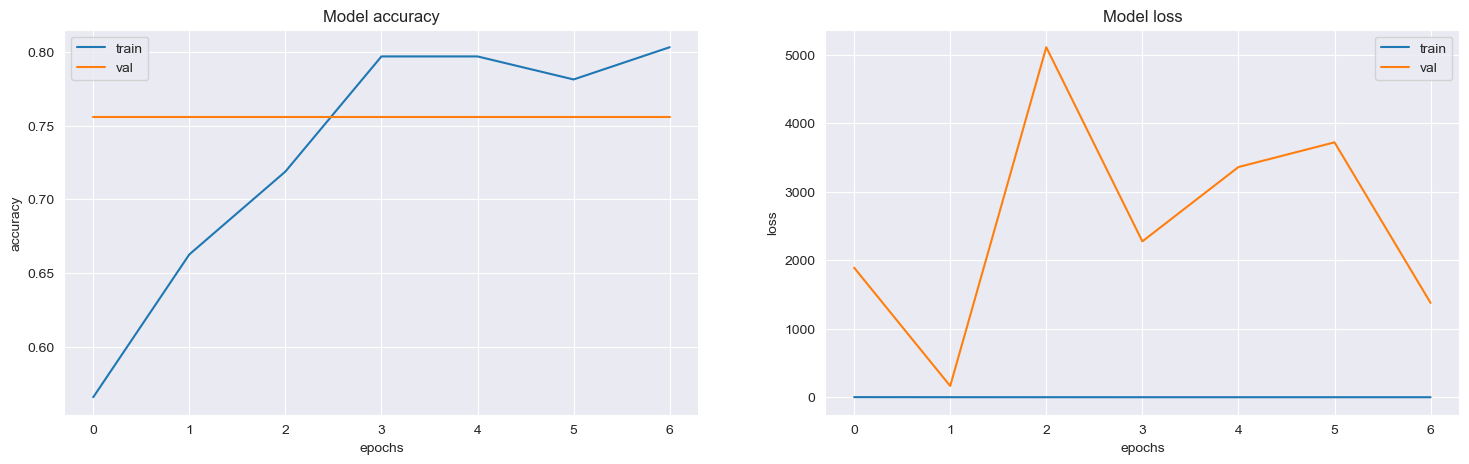

In [61]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [62]:
predictions = (model3.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:-1]

20/20 [==============================] - 28s 1s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [63]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



C:\Users\Gaurav\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gaurav\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gaurav\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
cm = confusion_matrix(y_test,predictions)
cm

array([[390,   0],
       [234,   0]], dtype=int64)

In [65]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

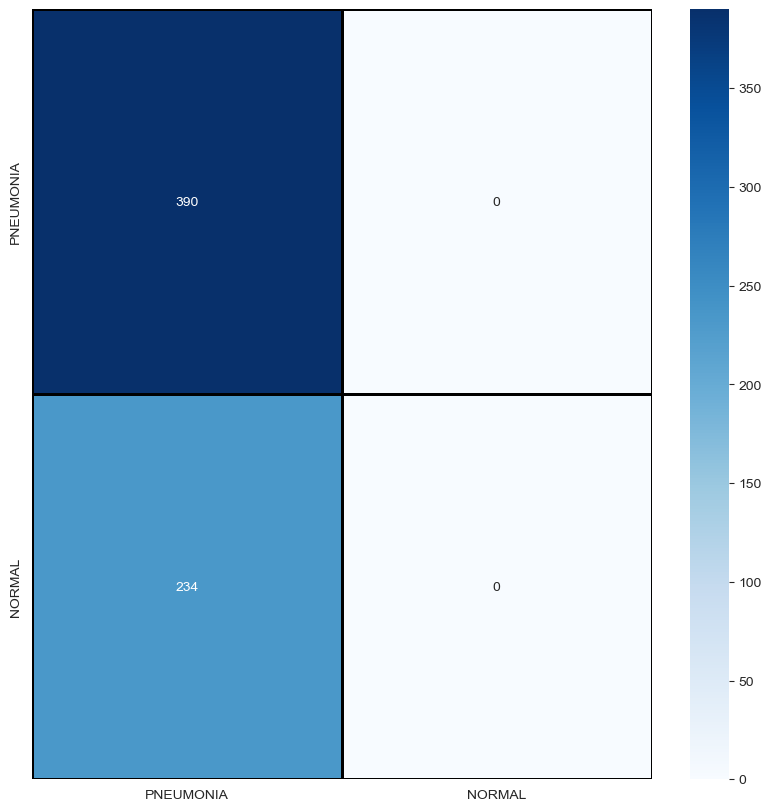

In [66]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [67]:
history = model3.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 5, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb3,early_stopping_cb3])

Epoch 1/5
10/10 [==============================] - 76s 8s/step - loss: 0.5397 - accuracy: 0.7156 - val_loss: 148360.0625 - val_accuracy: 0.7555
Epoch 2/5
10/10 [==============================] - 73s 8s/step - loss: 1.0137 - accuracy: 0.5844 - val_loss: 16560.8984 - val_accuracy: 0.7555
Epoch 3/5
10/10 [==============================] - 72s 8s/step - loss: 0.6259 - accuracy: 0.6938 - val_loss: 274.5935 - val_accuracy: 0.7555
Epoch 4/5
10/10 [==============================] - 73s 8s/step - loss: 0.4884 - accuracy: 0.7656 - val_loss: 1185.3624 - val_accuracy: 0.7555
Epoch 5/5
10/10 [==============================] - 73s 8s/step - loss: 0.4884 - accuracy: 0.7284 - val_loss: 949.9108 - val_accuracy: 0.7555


Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [68]:
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 25s 1s/step - loss: 1510.1498 - accuracy: 0.6250
Loss of the model is -  1510.1497802734375
20/20 [==============================] - 26s 1s/step - loss: 1510.1498 - accuracy: 0.6250
Accuracy of the model is -  62.5 %


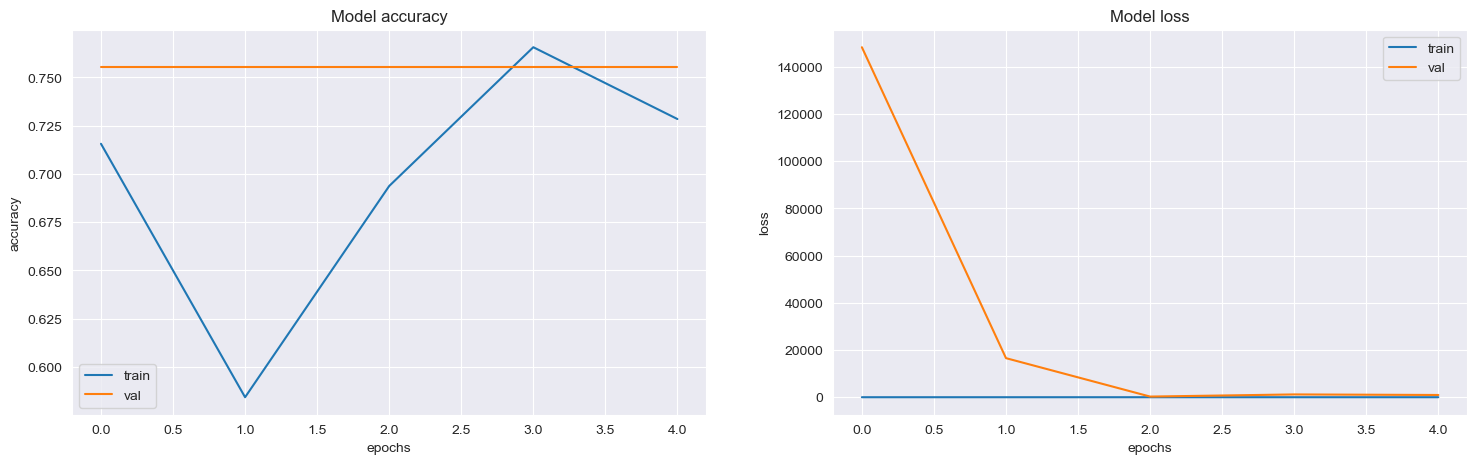

In [69]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [70]:
predictions = (model3.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:-1]

20/20 [==============================] - 26s 1s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [71]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



C:\Users\Gaurav\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gaurav\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gaurav\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
cm = confusion_matrix(y_test,predictions)
cm

array([[390,   0],
       [234,   0]], dtype=int64)

In [73]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

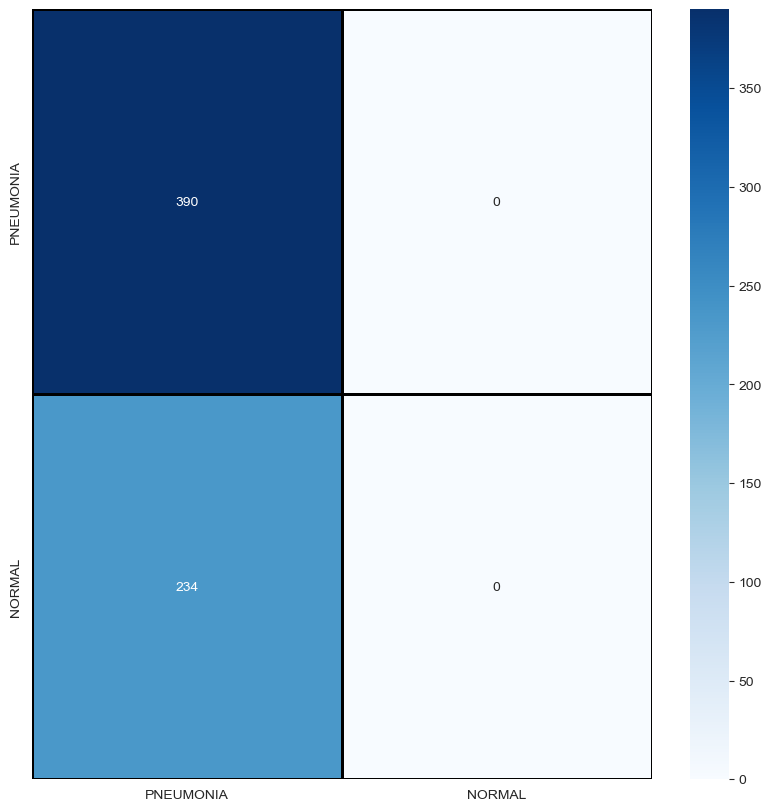

In [74]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)